In [1]:
from qiskit import *
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
import matplotlib as mpl
import pylatexenc


# Logic Gates

In [2]:
IBMQ.enable_account("83eab2c789e4b9b5030af0f6cdcf31f3efe4f59d505bff881e43504814b25b12526b1aa8c2b5826af475da8c49d3ca4f99189e59287d8040cb3750b728aa6b76")
provider = IBMQ.get_provider(hub="ibm-q")

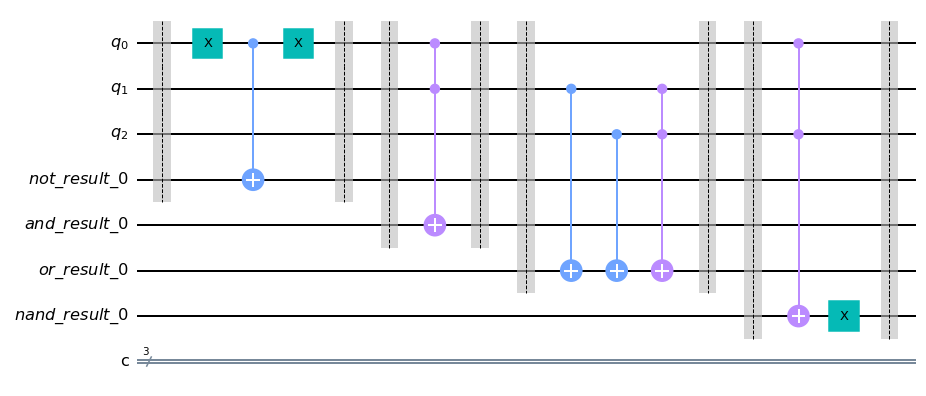

In [15]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
qc1 = QuantumCircuit(q,c)

#---------------------------------------------------------

def and_qbit(qc, bit1, bit2, output = QuantumRegister(1, 'and_result')):
    qc.add_register(output)
    qc.barrier()
    qc.ccx(bit1, bit2, output)
    qc.barrier()
    return output


def or_qbit(qc, bit1, bit2, output = QuantumRegister(1, 'or_result')):
    qc.add_register(output)
    qc.barrier()
    qc.cx(bit1, output)
    qc.cx(bit2, output)
    qc.ccx(bit1, bit2, output)
    qc.barrier()
    return output

def not_qbit(qc, bit, output = QuantumRegister(1, 'not_result')):
    qc.add_register(output)
    qc.barrier()
    qc.x(bit)
    qc.cx(bit, output)
    qc.x(bit)
    qc.barrier()
    return output

def nand_qbit(qc, bit1, bit2, output = QuantumRegister(1, 'nand_result')):
    qc.add_register(output)
    qc.barrier()
    qc.ccx(bit1, bit2, output)
    qc.x(output)
    qc.barrier()
    return output


not_qbit(qc1, q[0])
#-------------------------------------------
and_qbit(qc1, q[0], q[1])
#-------------------------------------------
or_qbit(qc1, q[1], q[2])
#-------------------------------------------
nand_qbit(qc1, q[0], q[2])
#-------------------------------------------
display(qc1.draw('mpl'))

# Recursive Circuit Gate Method Calls

Trying the adder circuit from the S = a + b + c

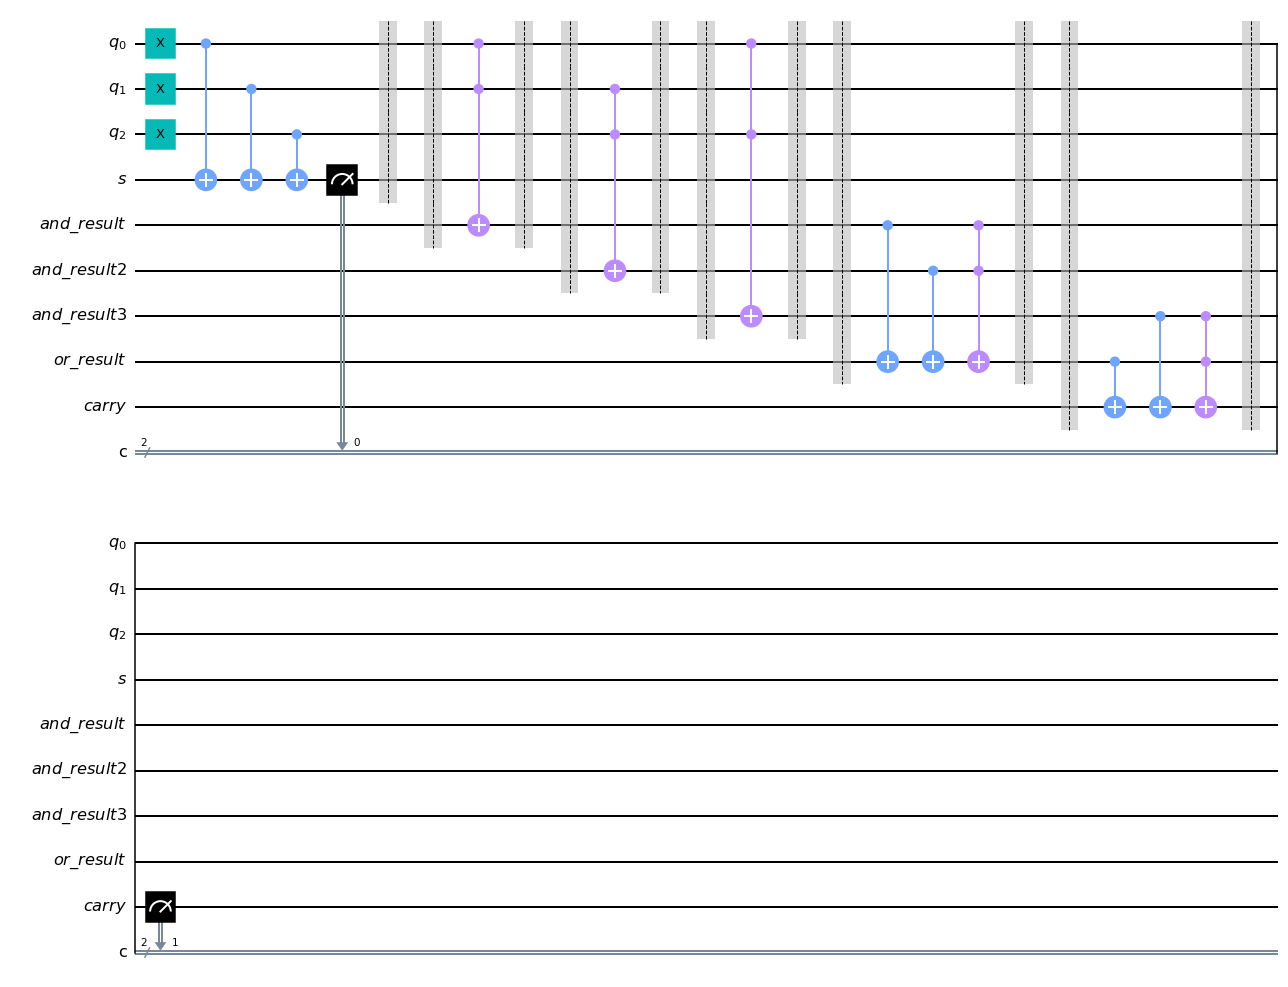

In [28]:
q4 = QuantumRegister(3,'q')
c4 = ClassicalRegister(2,'c')
qc4 = QuantumCircuit(q4,c4)

qc4.x(q4[0])
qc4.x(q4[1])
qc4.x(q4[2])

#calculate S
temp_sum = QuantumRegister(1, "s")
qc4.add_register(temp_sum)
qc4.cx(q4[0], temp_sum)
qc4.cx(q4[1], temp_sum)
qc4.cx(q4[2], temp_sum)
qc4.measure(temp_sum, 0)

qc4.barrier()
#calculate C (1 if 2+ arguments of a,b,c are 1)
temp_and = QuantumRegister(1, 'and_result')
and_qbit(qc4, q[0], q[1], temp_and)

temp_and2 = QuantumRegister(1, 'and_result2')
and_qbit(qc4, q[1], q[2], temp_and2)

temp_and3 = QuantumRegister(1, 'and_result3')
and_qbit(qc4, q[0], q[2], temp_and3)

temp_or = QuantumRegister(1, 'or_result')
or_qbit(qc4, temp_and, temp_and2, temp_or)

temp_or2 = QuantumRegister(1, 'carry')
or_qbit(qc4, temp_or, temp_and3, temp_or2)

qc4.measure(temp_or2, 1)

display(qc4.draw('mpl'))



In [26]:
backend = provider.get_backend("ibmq_qasm_simulator")
job = execute(qc4, backend, shots=1)
result = job.result()
counts = result.get_counts(qc4)
print("RESULT: ",counts,"\n")

RESULT:  {'11': 1} 



# Methods for recursive logic gate calls

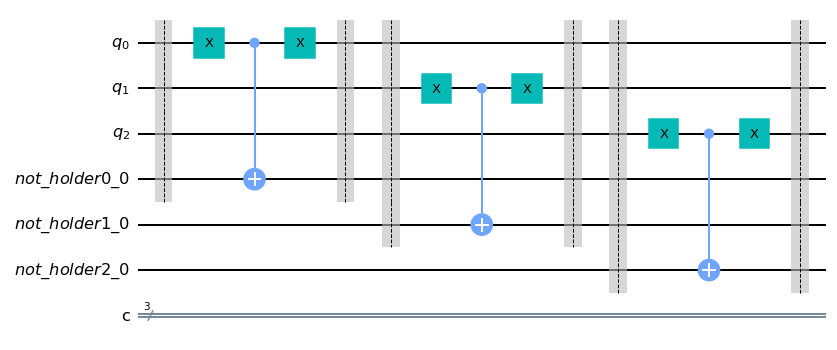

In [30]:
# methods for executing recursive and, or, not, nand gate calls

q_rec = QuantumRegister(3,'q')
c_rec = ClassicalRegister(3,'c')
qc_rec = QuantumCircuit(q_rec,c_rec)


def recursive_and(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            and_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "and_holder" + str(count)))

def recursive_or(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            or_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "or_holder" + str(count)))

def recursive_not(qc):
    len = qc.num_qubits
    for i in range(len):
        not_qbit(qc, qc.qubits[i], output=QuantumRegister(1, "not_holder" + str(i)))

def recursive_nand(qc):
    len = qc.num_qubits
    count = 0
    for i in range(len):
        x = i + 1
        for j in range(x, len):
            count = count + 1
            nand_qbit(qc, qc.qubits[i], qc.qubits[j], output=QuantumRegister(1, "nand_holder" + str(count)))


recursive_or(qc_rec)
#display(qc_rec.draw('mpl'))
recursive_and(qc_rec)
#display(qc_rec.draw('mpl'))
recursive_nand(qc_rec)
#display(qc_rec.draw('mpl'))
recursive_not(qc_rec)
#display(qc_rec.draw('mpl'))



# K bit Quantum Adder from two integers

111 10001
00111 10001


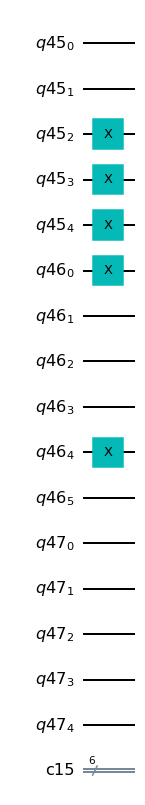

In [61]:
#given two integer values, build a quantum circuit to add them together
def adder(val1, val2):
    
    #------------ circuit initialization ------------
    
    bval = bin(val1)[2:]
    bval2 = bin(val2)[2:]
    print(bval, bval2)
    reg_len = max(len(bval), len(bval2))
    num_1 = QuantumRegister(reg_len) #qubits needed to represent first number
    num_2 = QuantumRegister(reg_len + 1) #qubits needed to represent second number & potential extra qubit for sum
    carry = QuantumRegister(reg_len) #qubits for carry bits
    class_holder = ClassicalRegister(reg_len + 1) #measurements result in sum
    qc = QuantumCircuit(num_1, num_2, carry, class_holder)

    #------------ normalizing binary strings to common length ------------

    diff = abs(len(bval) - len(bval2))
    prep = ''
    for i in range(diff):
        prep = prep + '0'
    if(len(bval) < len(bval2)): #normalize binary strings by prepending 0s
        bval = prep + bval
    elif(len(bval2) < len(bval)):
        bval2 = prep + bval2
    print(bval, bval2)


    #------------ transpose classical numbers to quantum bits ------------
    for j in range(len(bval)):
        if bval[j] == '1':
            qc.x(j)
    for k in range(len(bval2)):
        if bval2[k] == '1':
            qc.x(len(num_1) + k)
    display(qc.draw('mpl'))

    


adder(7, 17)